In [2]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 KB 6.0 MB/s eta 0:00:00a 0:00:01


In [16]:
import pandas as pd
# Wczytanie danych
data = pd.read_csv('cleaned_mbsa_onlycleanedtext.csv')

# Zamiana NaN na pusty ciąg znaków
data['text'] = data['text'].fillna('')

# Upewnienie się, że wszystkie wartości w kolumnie 'text' są typu string
data['text'] = data['text'].astype(str)

Podstawowe informacje o danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15803213 entries, 0 to 15803212
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Date       object
 1   text       object
 2   Sentiment  object
dtypes: object(3)
memory usage: 361.7+ MB
None

Podsumowanie wartości unikalnych w kolumnie 'Sentiment':
Sentiment
Negative    8013794
Positive    7789124
Neutral         295
Name: count, dtype: int64


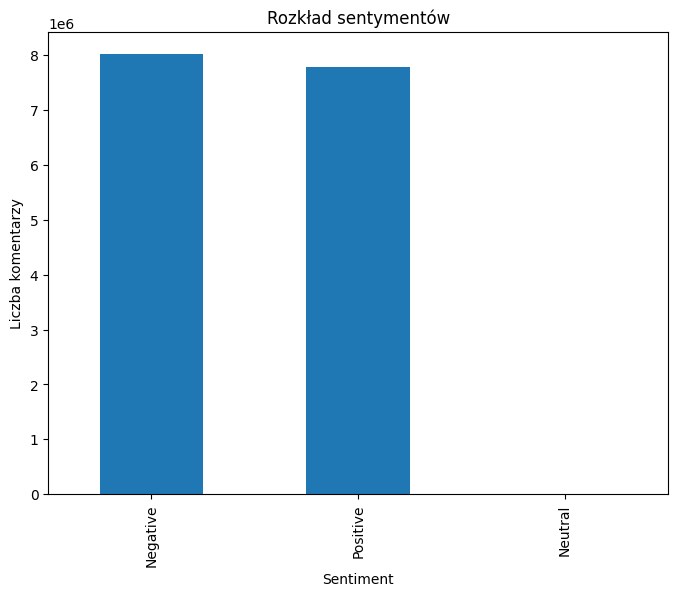

In [6]:
# Importowanie bibliotek
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Wczytanie danych
data = pd.read_csv('cleaned_mbsa_onlycleanedtext.csv')

# Podstawowe informacje o zbiorze danych
print("Podstawowe informacje o danych:")
print(data.info())
print("\nPodsumowanie wartości unikalnych w kolumnie 'Sentiment':")
print(data['Sentiment'].value_counts())

# Rozkład sentymentów
sentiment_counts = data['Sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', title='Rozkład sentymentów')
plt.xlabel('Sentiment')
plt.ylabel('Liczba komentarzy')
plt.show()



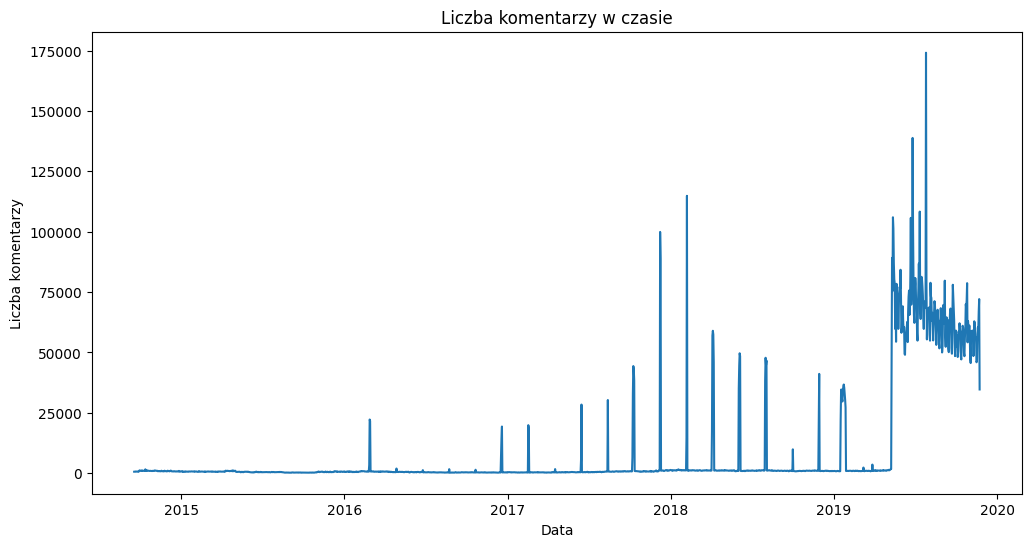

In [7]:
# Analiza czasowa (jeśli 'Date' jest w formacie daty)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['Date'].groupby(data['Date'].dt.date).count().plot(
    figsize=(12, 6), title="Liczba komentarzy w czasie", xlabel="Data", ylabel="Liczba komentarzy"
)
plt.show()


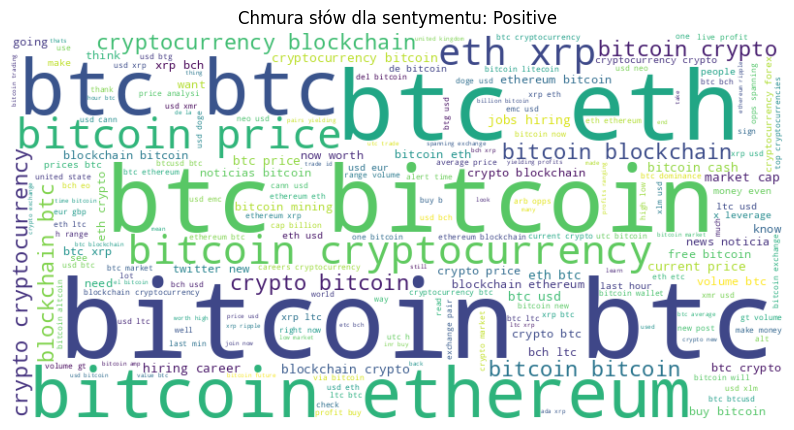

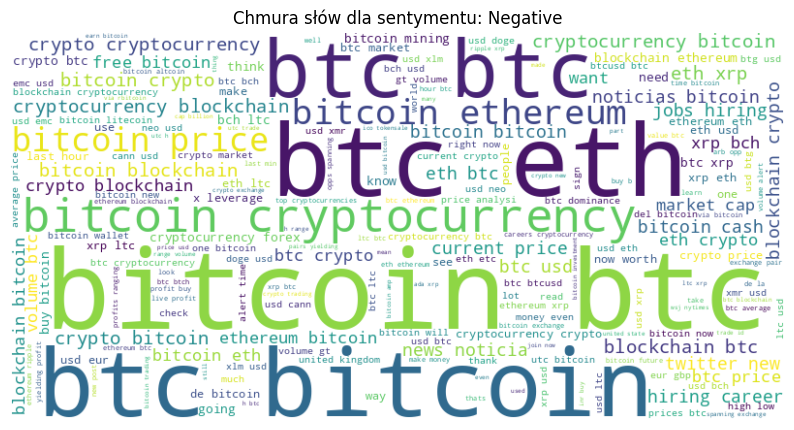

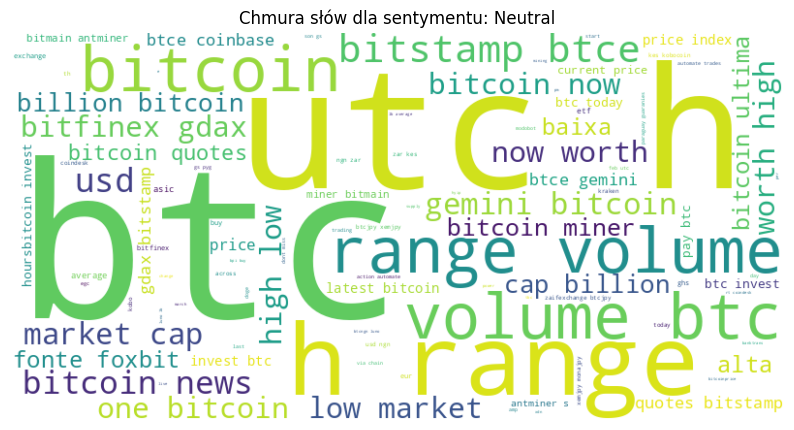

In [9]:
# Zamiana NaN na pusty ciąg znaków
data['text'] = data['text'].fillna('')

# Upewnienie się, że wszystkie wartości w kolumnie 'text' są typu string
data['text'] = data['text'].astype(str)

# Tworzenie chmury słów dla każdego sentymentu
for sentiment in data['Sentiment'].unique():
    sentiment_texts = " ".join(data[data['Sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_texts)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Chmura słów dla sentymentu: {sentiment}")
    plt.show()

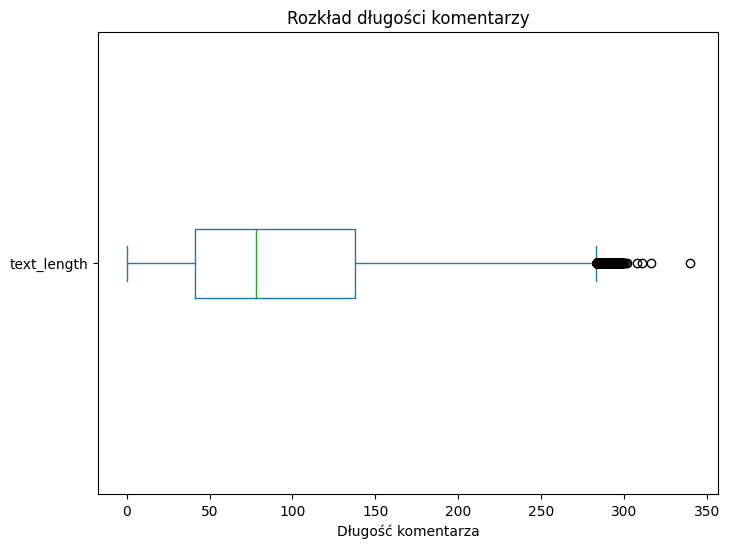

Liczba komentarzy z długością mniejszą niż 5: 784269


In [10]:
# Długość komentarzy
data['text_length'] = data['text'].apply(len)

# Analiza długości komentarzy
plt.figure(figsize=(8, 6))
data['text_length'].plot(kind='box', vert=False, title="Rozkład długości komentarzy")
plt.xlabel('Długość komentarza')
plt.show()

# Filtracja anomalii (np. bardzo krótkie komentarze)
threshold = 5  # minimalna długość komentarza
anomalies = data[data['text_length'] < threshold]
print(f"Liczba komentarzy z długością mniejszą niż {threshold}: {len(anomalies)}")


              word     count
2          bitcoin  10452792
4              btc   8246906
6           crypto   2474743
7   cryptocurrency   1753847
8              eth   1665875
3       blockchain   1576490
18             usd   1505360
15           price   1492238
19             xrp   1175994
9         ethereum   1005953
11             ltc    731166
12          market    682125
17         trading    672476
5              buy    671036
0              bch    621605
13           money    564496
10            free    546981
14            news    531456
16            time    520783
1          binance    515827


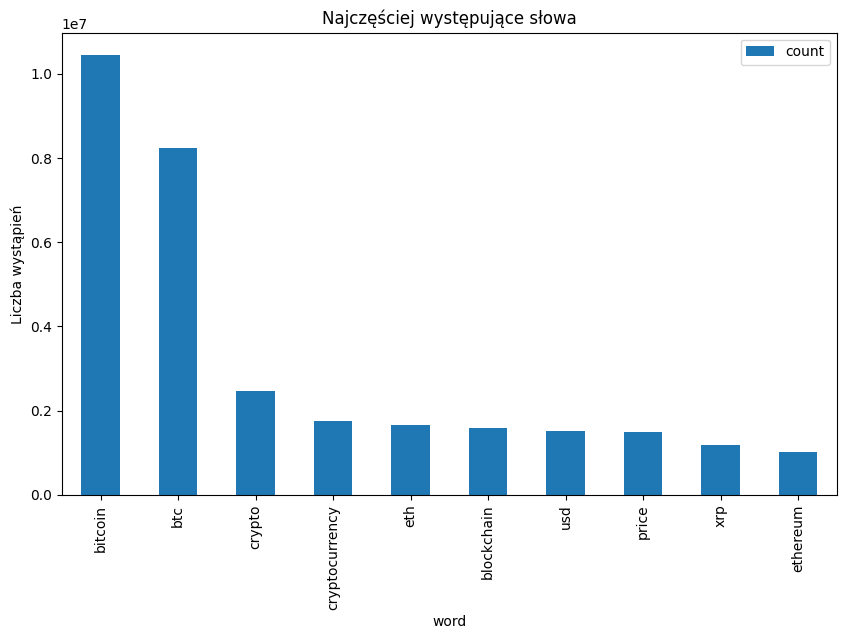

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_matrix = vectorizer.fit_transform(data['text'])
word_counts = word_matrix.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Wizualizacja
word_freq = pd.DataFrame({'word': words, 'count': word_counts})
word_freq = word_freq.sort_values(by='count', ascending=False)
print(word_freq)

# Wykres
word_freq.set_index('word').head(10).plot(kind='bar', figsize=(10, 6), title='Najczęściej występujące słowa')
plt.ylabel('Liczba wystąpień')
plt.show()


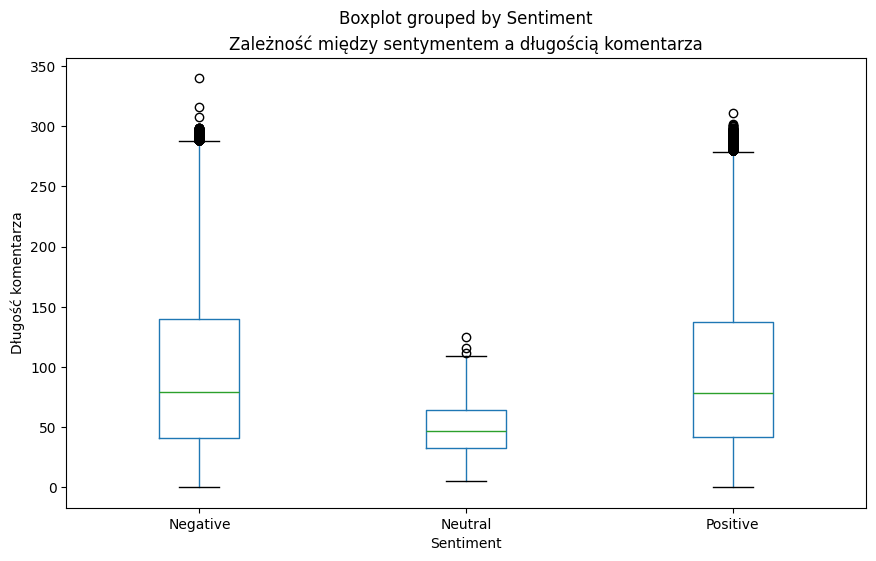

In [12]:
data.boxplot(column='text_length', by='Sentiment', grid=False, figsize=(10, 6))
plt.title('Zależność między sentymentem a długością komentarza')
plt.xlabel('Sentiment')
plt.ylabel('Długość komentarza')
plt.show()


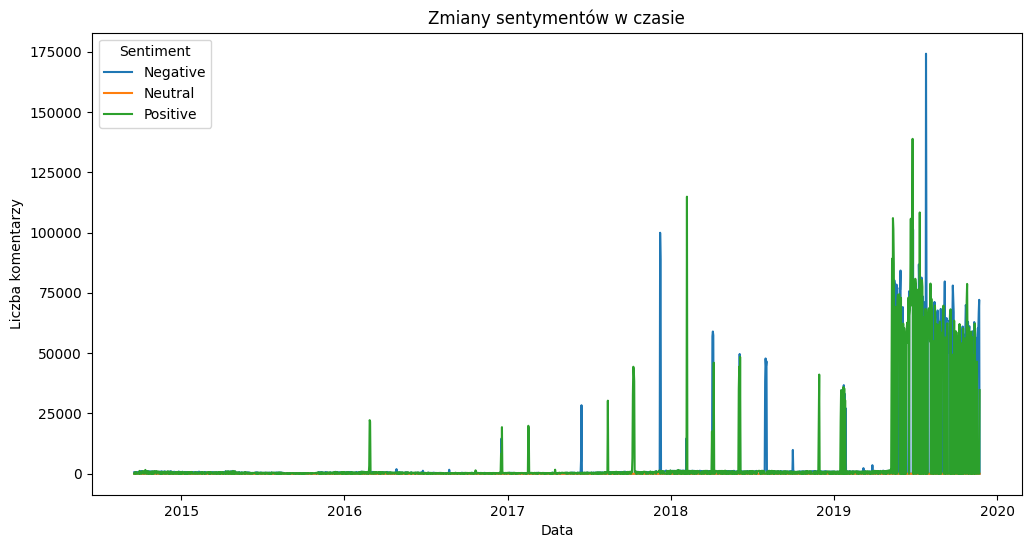

In [13]:
sentiment_over_time = data.groupby([data['Date'].dt.date, 'Sentiment']).size().unstack(fill_value=0)
sentiment_over_time.plot(figsize=(12, 6), title="Zmiany sentymentów w czasie")
plt.xlabel('Data')
plt.ylabel('Liczba komentarzy')
plt.show()


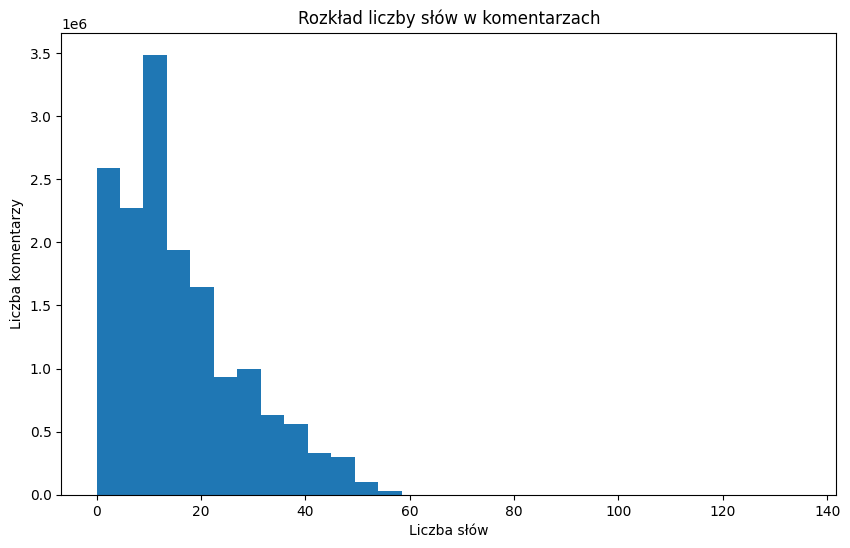

In [14]:
from nltk.tokenize import word_tokenize

data['word_count'] = data['text'].apply(lambda x: len(word_tokenize(x)))
data['word_count'].plot(kind='hist', bins=30, figsize=(10, 6), title='Rozkład liczby słów w komentarzach')
plt.xlabel('Liczba słów')
plt.ylabel('Liczba komentarzy')
plt.show()


In [17]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from tqdm import tqdm
tqdm.pandas()

# Zabezpieczenie dla powtarzalnych wyników
DetectorFactory.seed = 0

# Funkcja do wykrywania języka
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Dodanie kolumny z językiem
data['language'] = data['text'].progress_apply(detect_language)

# Zapisanie danych do pliku CSV
data.to_csv('data_with_languages.csv', index=False)

# Filtracja angielskich komentarzy
english_comments = data[data['language'] == 'en']

# Usunięcie kolumny 'language'
english_comments = english_comments.drop(columns=['language'])

# Sprawdzenie liczby angielskich komentarzy
print(f"Liczba angielskich komentarzy: {len(english_comments)}")

# Zapisanie do pliku CSV bez kolumny 'language'
english_comments.to_csv('english_comments.csv', index=False)

# Analiza występowania języków
language_counts = data['language'].value_counts()
print("Najczęściej występujące języki:")
print(language_counts)

# Wizualizacja rozkładu języków
plt.figure(figsize=(12, 6))
language_counts.head(10).plot(kind='bar', title='Najczęściej występujące języki w komentarzach')
plt.xlabel('Język')
plt.ylabel('Liczba komentarzy')
plt.show()


  2%|▌                            | 329694/15803213 [33:34<26:16:02, 163.63it/s]


KeyboardInterrupt: 

In [ ]:
# Zapisanie danych z dodaną kolumną języka do pliku CSV
data.to_csv('data_with_languages.csv', index=False)